# Fitting Rotation Maps with Warps

This Notebook will discuss to include a warp in the fitting of rotation maps.

## Warps

### Parameterization

A warp is implemented as a spatially varying inclination. We have chosen to use the function,

$$z_{\rm warp}(r,\, \phi) = r \times \tan \left[ w_i \cdot \sin(\phi - w_t) \cdot \exp \left( -\frac{1}{2} \frac{r^2}{w_r^2}\right) \right]$$

which describes an inclination which varies radially as a Gaussian. $w_{\phi}$ describes the angle of nodes, that is $z_{\rm warp}(r,\, \phi=w_t) = 0$. In principle any function would be within $\tan [\cdots]$, however we have found this provides sufficient flexibility to describe most cases. $w_t$ is measured from $\phi = 0$ in an eastward direction. Note that other applications, for example in galactic dynamics, use a power-law represention however this diverges at $r = 0$ so we avoid that implementation.

### Shadowing

For high inclination sources, typically $i \gtrsim 50^{\circ}$, extreme warps can shadow regions of the disk. A good first check is to improve the number of iterations to use in the deprojection with

```python
rotationmap.disk_coords_niter = 20
```

where the default is 5. If this doesn't solve it then this isn't a problem, however the typical iterative approach we've used to deproject the coordinates will fail here. If this is likely the case you must use

```python
params['shadowed'] = True
```

which will invoke `_get_shadowed_coords()` rather than `get_flared_coords()`. This forward models the deprojection and interpolates this onto the sky plane which is more computationally expensive. A quick check could be to use `disk_coords()` with and without the `shadowed` argument and looking at the returned contours.

## Application to TW Hya

Doesn't show anything but just an example for now...

In [1]:
# Load up the packages.
%matplotlib inline
from multiprocessing import Pool
from eddy.fit_cube import rotationmap

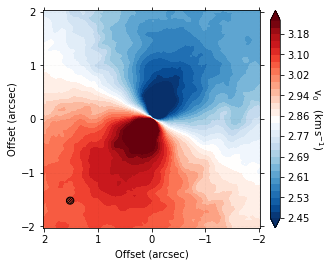

In [3]:
# Load up the data. We are only interested in the inner 1".
cube = rotationmap(path='../../notebooks/cubes/TWHya_CO_cube_v0.fits',
                   uncertainty='../../notebooks/cubes/TWHya_CO_cube_dv0.fits',
                   clip=2.0, downsample=5)
cube.plot_data()

Assuming:
	p0 = [${\rm x0}$, ${\rm y0}$, ${\rm PA}$, ${\rm mstar}$, ${\rm vlsr}$].
Optimized starting positions:
	p0 = ['1.20e-03', '2.28e-02', '1.51e+02', '5.87e-01', '2.84e+03']


100%|██████████| 1200/1200 [06:03<00:00,  3.37it/s]


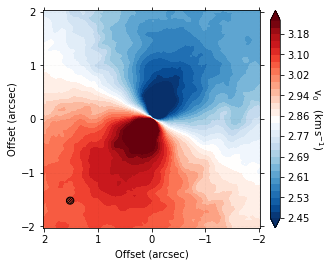

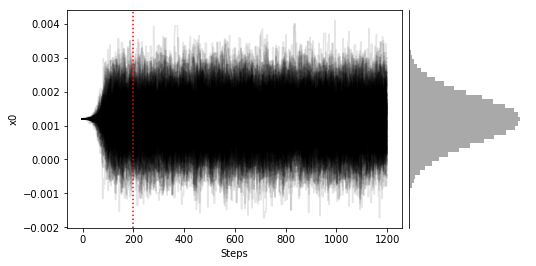

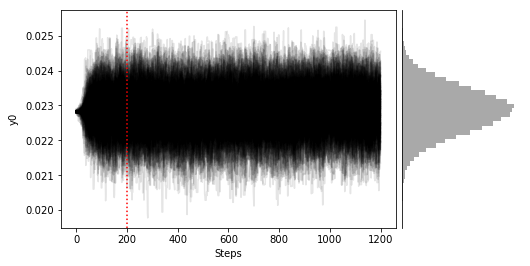

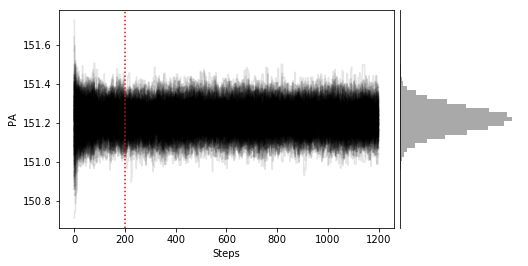

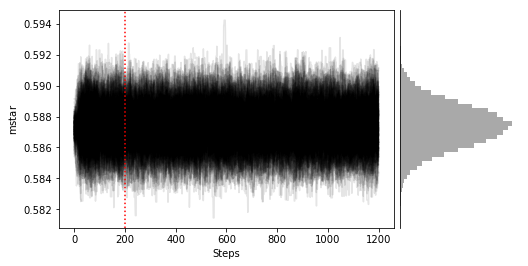

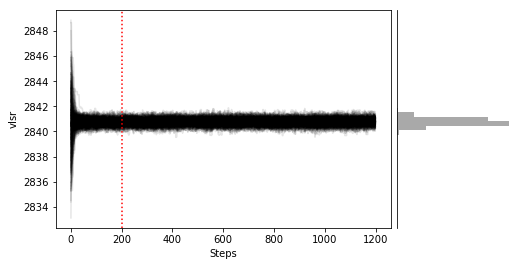

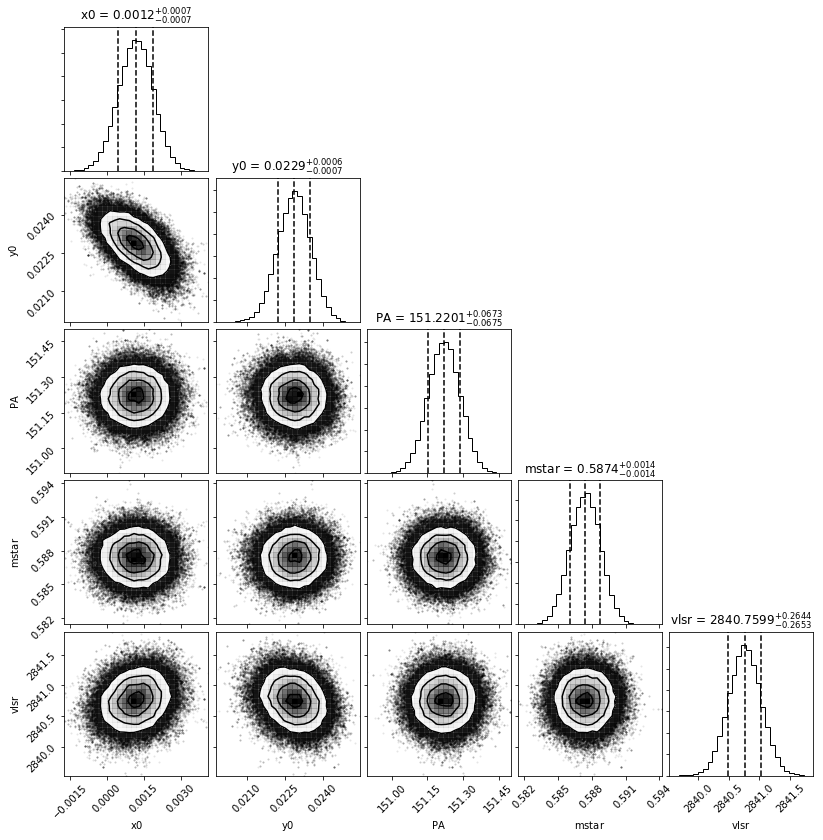

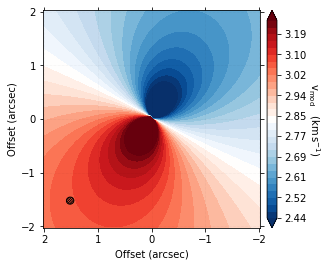

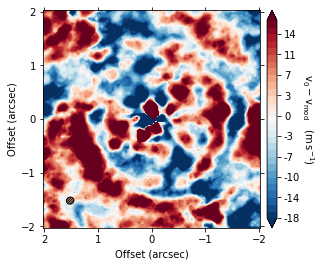

In [4]:
# Start with simple flat disk approach.

params = {}
params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4
p0 = [-6.2e-3, 4.6e-3, 151.0, 0.57, 2.84e3]

# Fix the other parameters.

params['inc'] = 6.8    # degrees 
params['dist'] = 60.1  # parsec

# Run this in parallel.
with Pool() as pool:
    _ = cube.fit_keplerian(p0=p0, params=params, nwalkers=256, nburnin=200, nsteps=1000, pool=pool)

Pretty nasty residuals, huh.

Trying with a warp and a flared emission surface just to see what happens. We also set `niter=4` to restart the sampler four times, so we take in total 4 x 600 steps, each time recentering on the median values of the samples from the previous run.

Assuming:
	p0 = [${\rm x0}$, ${\rm y0}$, ${\rm PA}$, ${\rm mstar}$, ${\rm vlsr}$, ${\rm w_i}$, ${\rm w_r}$, ${\rm w_t}$, ${\rm z0}$, ${\rm psi}$].


100%|██████████| 1200/1200 [05:31<00:00,  4.10it/s]


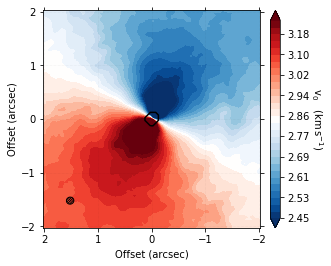

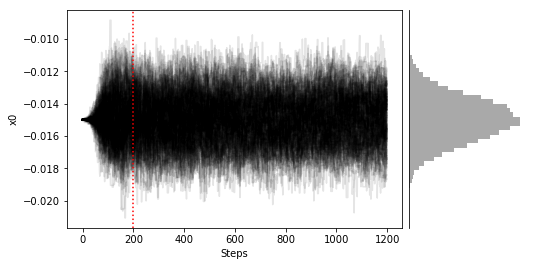

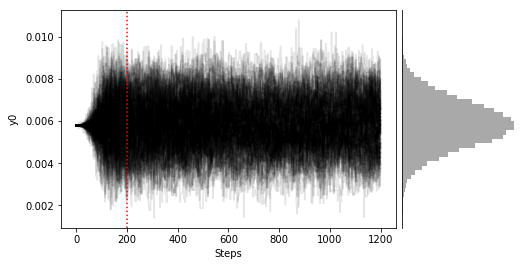

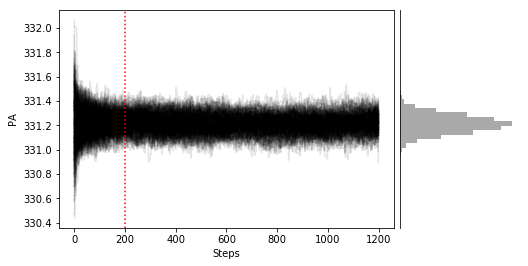

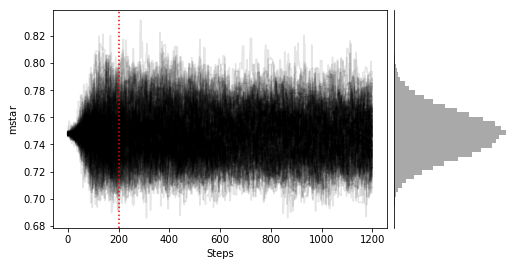

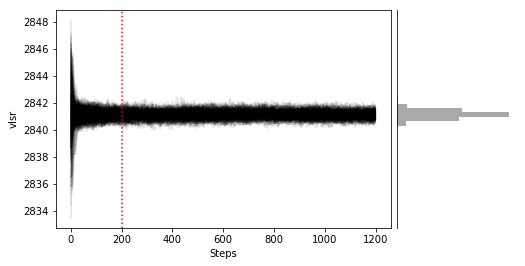

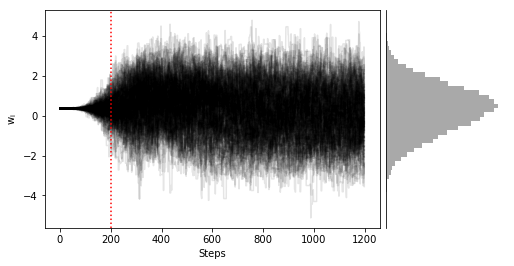

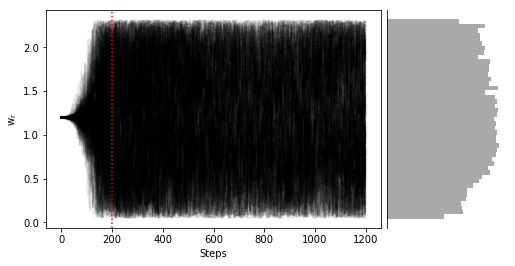

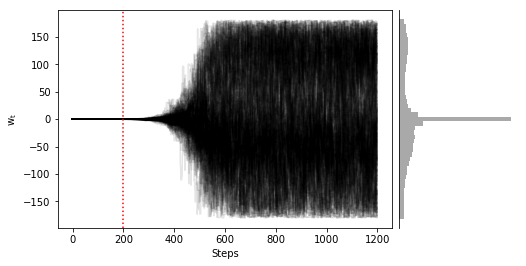

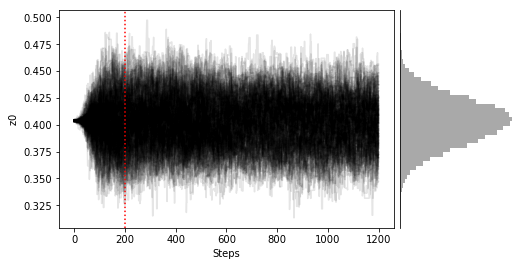

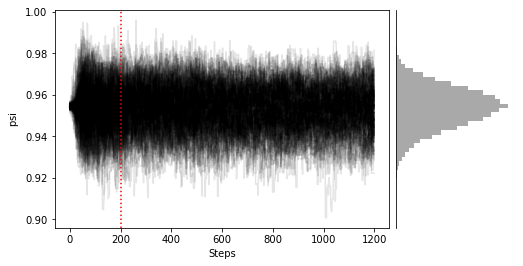

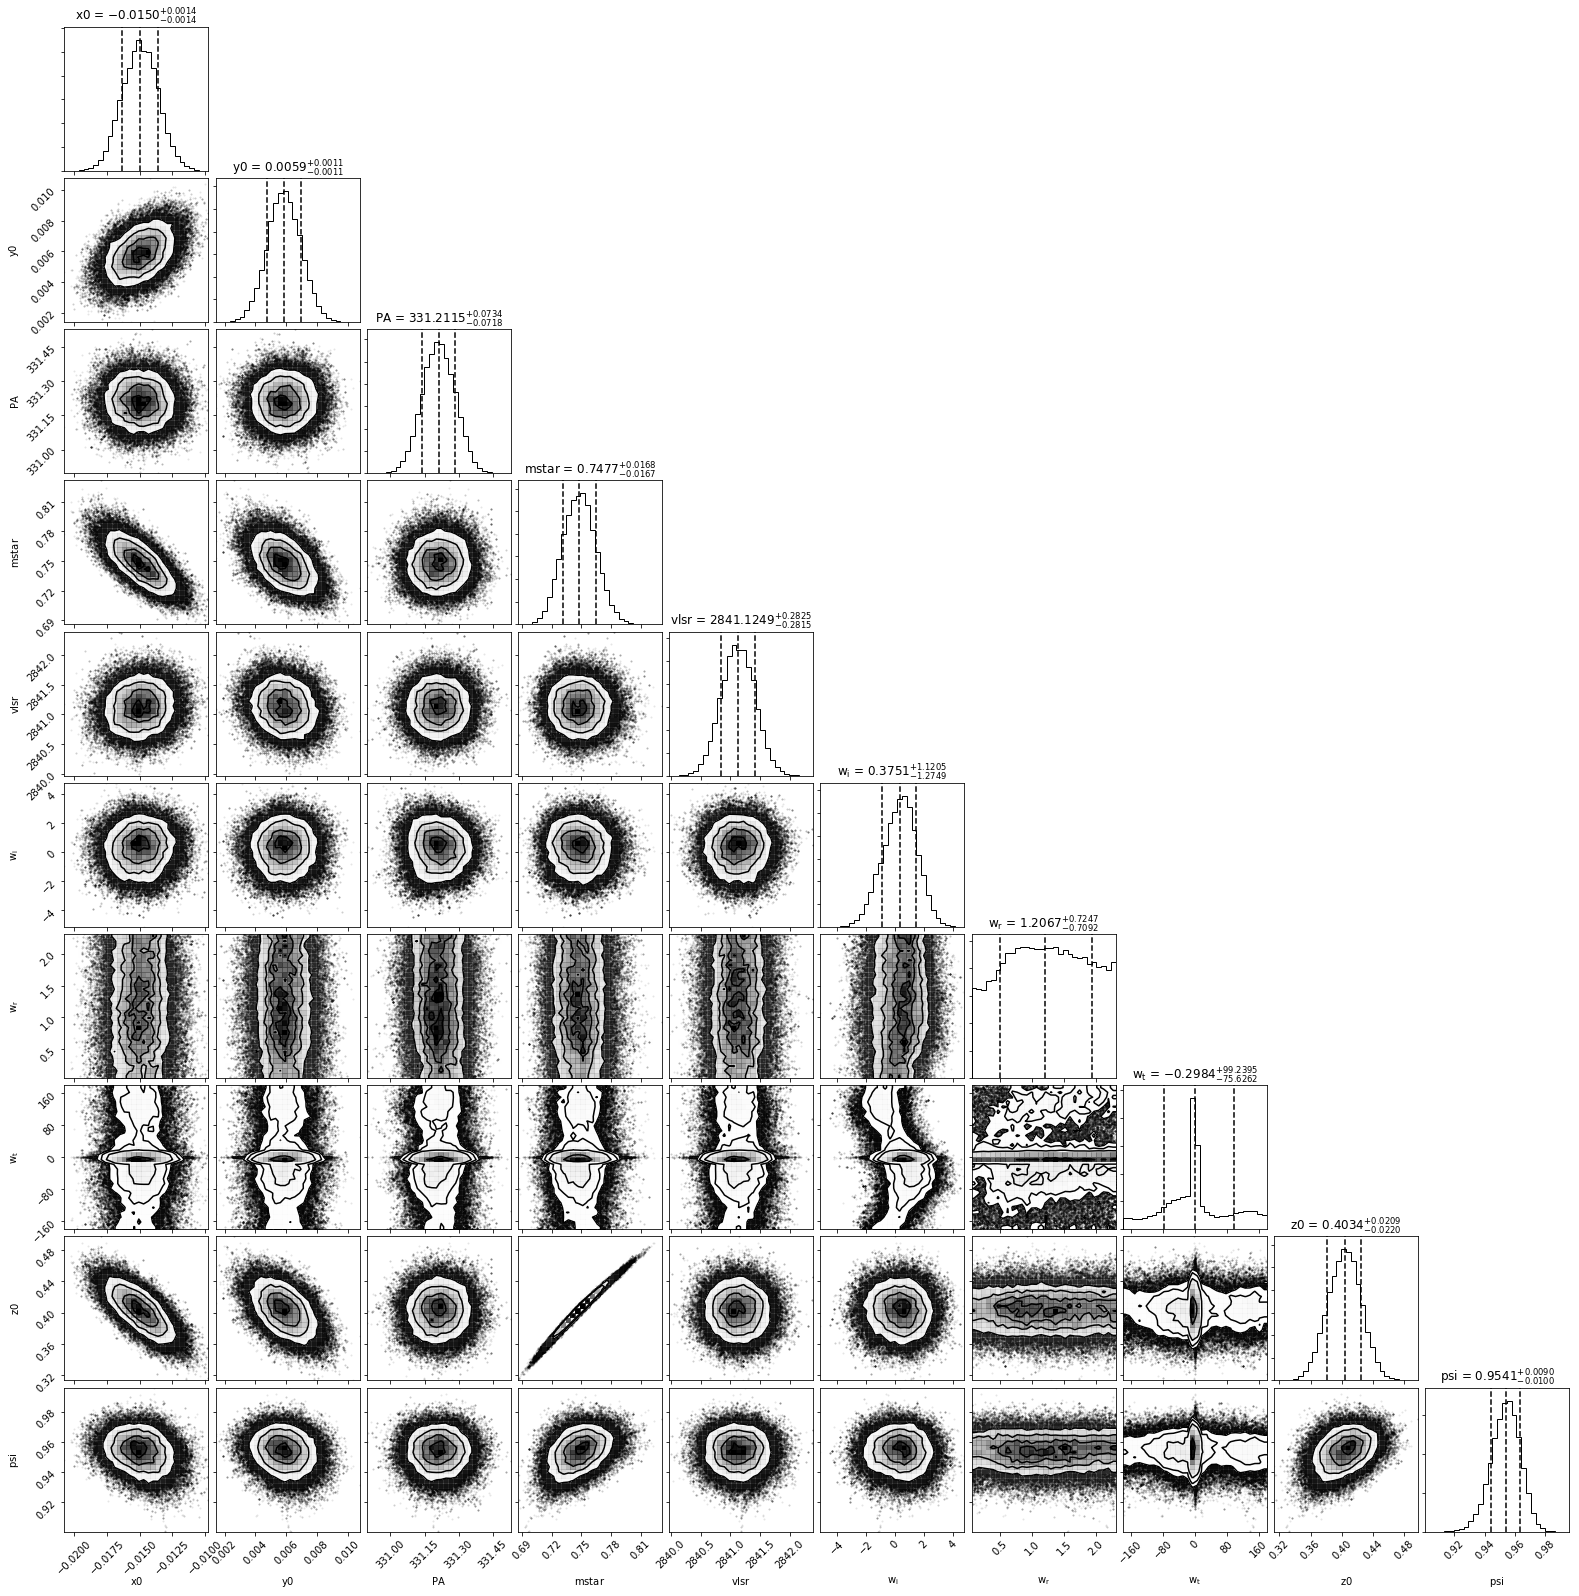

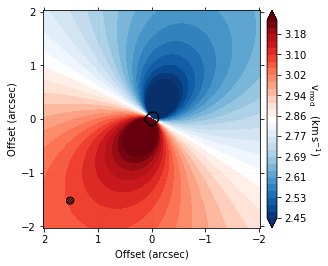

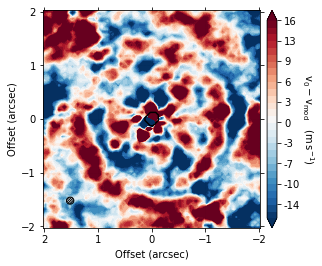

In [5]:
# Fix the source parameters.
params = {}
params['inc'] = -6.8
params['dist'] = 60.1

# Start with simple flat disk approach.
params['x0'] = 0
params['y0'] = 1
params['PA'] = 2
params['mstar'] = 3
params['vlsr'] = 4
p0 = [-6.2e-3, 4.6e-3, 151.0, 0.57, 2.84e3]

# Include the warp properties.
params['w_i'] = 5
params['w_r'] = 6
params['w_t'] = 7
p0 += [3.0, 0.5, 0.0]

# Include a priors that the warp should be negligible.
cube.set_prior('w_i', [0.0, 1.0], 'gaussian')

# Include the flaring properties.
params['z0'] = 8
params['psi'] = 9
p0 += [0.1, 0.5]


# Run this in parallel.
with Pool() as pool:
    _ = cube.fit_keplerian(p0=p0, params=params, nwalkers=256, nburnin=200, nsteps=1000,
                           r_min=cube.bmaj, pool=pool, niter=4, optimize=False)

# Default the 
cube._set_default_priors()